In [6]:
import ee
import datetime
import os
import itertools
import sys

from pprint import pprint
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import geemap

import subprocess
from subprocess import PIPE

In [7]:
ee.Initialize()

In [8]:
# define basic parameters
year_range = [f'{i}_{i+2}' for i in range(1990,2020,3)]

In [9]:
year_range

['1990_1992',
 '1993_1995',
 '1996_1998',
 '1999_2001',
 '2002_2004',
 '2005_2007',
 '2008_2010',
 '2011_2013',
 '2014_2016',
 '2017_2019']

In [8]:
North_China_Plain = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Boundary_shp/North_China_Plain_Boundary")

### calculate the area change of the classification

##### Import my result, GAIA and GIP_2015 

In [63]:
# get the temporal_check classification images
Checked_img = [ee.Image(f"users/wangjinzhulala/North_China_Plain_Python/classificatioin_temporal_checked/forward_backward_Window_3_It_9_{year}")
               for year in year_range]

# get the GAIA classification product
GAIA_img = ee.Image("users/wangjinzhulala/North_China_Plain_Python/Reference_classification/GAIA_NCP")

# get the Global Impervious Surface of 2015
GIP_2015 = ee.Image("users/wangjinzhulala/North_China_Plain_Python/Reference_classification/Global_Impervious_Surface_2015_NCP")\
             .remap([1,2],[0,1]).rename('b1')

##### Calculate the area change from my product

In [25]:
# get the pixel count of my classifications
Stats_my = [img.reduceRegion(reducer   = ee.Reducer.sum(), 
                             geometry  = North_China_Plain.geometry().bounds(), 
                             scale     = 30, 
                             maxPixels = int(1e13))
            for img in Checked_img]

Stats_my = [int(st.getInfo()['b1']) for st in Stats_my]

##### Calculate the area change from GAIA

In [ ]:
# get the GAIA area change
GAIA_value = dict(zip(range(1985,2019),range(34,0,-1)))

# add {2019:1} to the dictionary, because GAIA does not 
# extend to 2019, we just use its latest pixel of 2018
GAIA_value.update({2019:1})

# here we get each end year (1992,1995,...,2019) from GAIA
# set the target year's value to 1, others to 0
GAIA_each_year = [ee.Image(GAIA_img.gte(GAIA_value[year])) 
                  for year in range(1992,2020,3)]

In [50]:
# get the area change from GAIA product
Stats_GAIA = [img.reduceRegion( reducer   = ee.Reducer.sum(), 
                                geometry  = North_China_Plain.geometry().bounds(), 
                                scale     = 30, 
                                maxPixels = int(1e13))
             for img in GAIA_each_year]

Stats_GAIA = [int(st.getInfo()['b1']) for st in Stats_GAIA]

##### Calculate the area of GIP_2015

In [64]:
Stats_GIP_2015 = GIP_2015.reduceRegion( reducer   = ee.Reducer.sum(), 
                                geometry  = North_China_Plain.geometry().bounds(), 
                                scale     = 30, 
                                maxPixels = int(1e13))
                                       
Stats_GIP_2015 = int(Stats_GIP_2015.getInfo()['b1'])                                     

##### Store the status into a dataframe

In [12]:
# # contruct the datafram
# Status_df = pd.DataFrame(data={'My':Stats_GAIA,'GAIA':Stats_GAIA,'GIP_2015':Stats_GIP_2015})

# # save to dis
# Status_df.to_csv('./Result/Area_change.csv',index=False)

# load the df
Status_df = pd.read_csv('./Result/Area_change.csv')

In [13]:
Status_df['Year'] = year_range
Status_df

,My,GAIA,GIP_2015,Year
0,64144522,43218031,92236274,1990_1992
1,78182338,49081462,92236274,1993_1995
2,91296920,55003118,92236274,1996_1998
3,95251043,63251823,92236274,1999_2001
4,102076019,71112123,92236274,2002_2004
5,110143733,79315124,92236274,2005_2007
6,118845175,89055367,92236274,2008_2010
7,128094086,106342084,92236274,2011_2013
8,145370707,129429229,92236274,2014_2016
9,157973045,131598996,92236274,2017_2019


#### Observe that there is a noticibel dirrerence in total area between my result and the GAIA

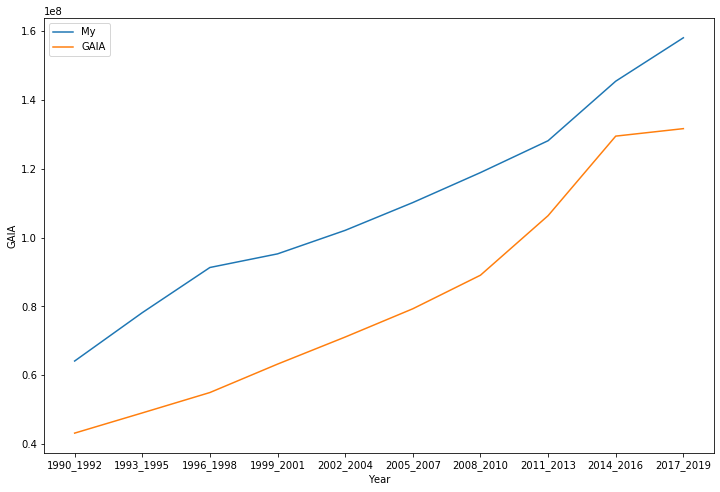

In [15]:
plt.figure(figsize=(12,8))

sns.lineplot(data=Status_df,x='Year',y='My',label='My')
sns.lineplot(data=Status_df,x='Year',y='GAIA',label='GAIA')